### Air Quality Prediction 

### Step 1 - Data Collection 

We will do webscrapping of AQI Data from below Website 
- https://en.tutiempo.net/

We will do webscrapping of Mumbai from above website (2013-2019) -- You can see the Month Wise Data for Each state in Website
- https://en.tutiempo.net/india.html

Link for Banglore Weather
- https://en.tutiempo.net/climate/ws-432950.html

Link for Banglore -- Year and Month Example
- https://en.tutiempo.net/climate/01-2020/ws-432950.html

###### Features Description

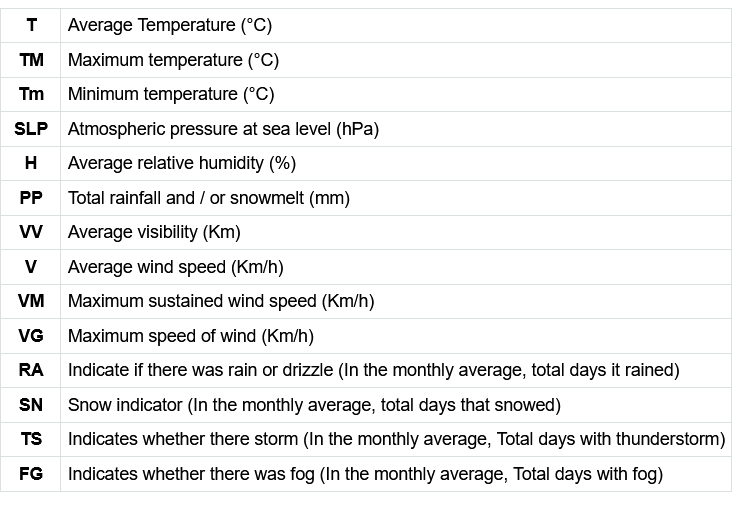

#### Webscrapping Data from Above Link 

In [1]:
import os
import time
import requests ##It helps us to download html 
import sys

def retrieve_html():
    ## Extracting data from 5 years
    for year in range(2013,2019):
        for month in range(1,13):
            if(month<10):
                url='http://en.tutiempo.net/climate/0{}-{}/ws-421820.html'.format(month,year)
            else:
                url='http://en.tutiempo.net/climate/{}-{}/ws-421820.html'.format(month,year)
            texts = requests.get(url)
            text_utf = texts.text.encode('utf=8')

            if not os.path.exists('Data/Html_Data/{}'.format(year)):
                os.makedirs('Data/Html_Data/{}'.format(year))

            with open('Data/Html_Data/{}/{}.html'.format(year,month),"wb") as output:
                output.write(text_utf)

        sys.stdout.flush() 
        
start_time = time.time()
retrieve_html()
end_time = time.time()

print("Time taken {}".format(end_time-start_time))

Time taken 645.9158372879028


### Dependent Variable - Data Collection

CSV File Contains data of each and every Hour of the Day.We will have to do data cleaning before merging it with the Independent Variables

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df_temp = pd.read_csv('Data/AQI/aqi2013.csv')
df_temp.head(25)

,Date,Time,PM2.5,PM2.5 AQI
0,1/1/2013,1:00 AM,324.4,238
1,1/1/2013,2:00 AM,366.8,243
2,1/1/2013,3:00 AM,290.7,250
3,1/1/2013,4:00 AM,245.4,254
4,1/1/2013,5:00 AM,220.3,259
5,1/1/2013,6:00 AM,180.2,262
6,1/1/2013,7:00 AM,140,264
7,1/1/2013,8:00 AM,125,265
8,1/1/2013,9:00 AM,111,265
9,1/1/2013,10:00 AM,112,264


### Taking Average of all 24Hrs of Each and Every Day of Each year - 2013-2018

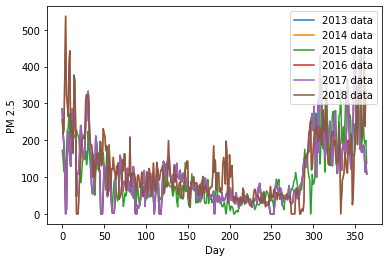

In [15]:
def avg_data_year(year):
    temp_i=0
    average=[]
    ### We will take records in ChunkSize i-e 24 Hrs of Each day
    for rows in pd.read_csv('Data/AQI/aqi{}.csv'.format(year),chunksize=24):
        add_var=0
        avg=0.0
        data=[]
        df=pd.DataFrame(data=rows)
        ### Append Value of Each Row of Column PM2.5 in data list
        for index,row in df.iterrows():
            data.append(row['PM2.5'])
        for i in data:
            if type(i) is float or type(i) is int:
                add_var=add_var+i
            elif type(i) is str:
                if i!='NoData' and i!='PwrFail' and i!='---' and i!='InVld':
                    ### Value can also be in Str -- "22" -- So we will convert that into float and add it in add_var 
                    temp=float(i)
                    add_var=add_var+temp
        avg=add_var/24
        temp_i=temp_i+1
        
        average.append(avg)
    return average

lst2013=avg_data_year('2013')
lst2014=avg_data_year('2014')
lst2015=avg_data_year('2015')
lst2016=avg_data_year('2016')
lst2017=avg_data_year('2017')
lst2018=avg_data_year('2018')
#print("Length of Each Year {} ".format(len(lst2013)))
plt.plot(range(0,365),lst2013,label="2013 data")
plt.plot(range(0,364),lst2014,label="2014 data")
plt.plot(range(0,365),lst2015,label="2015 data")
plt.plot(range(0,365),lst2016,label="2016 data")
plt.plot(range(0,365),lst2017,label="2017 data")
plt.plot(range(0,364),lst2018,label="2018 data")
plt.xlabel('Day')
plt.ylabel('PM 2.5')
plt.legend(loc='upper right')
plt.show()

### Creating Final Dataset with Independent and Dependent Variables 

In [52]:
from bs4 import BeautifulSoup ## Extracting Information from HTML page
import csv

def met_data(month, year):
    
    file_html = open('Data/Html_Data/{}/{}.html'.format(year,month), 'rb')
    plain_text = file_html.read()
  
    tempD = []
    finalD = []

    soup = BeautifulSoup(plain_text, "lxml")
    ## To extract a table from html -- See if you can find class name .
    for table in soup.findAll('table', {'class': 'medias mensuales numspan'}):
        for tbody in table:
            for tr in tbody:
                a = tr.get_text()
                tempD.append(a)
    # From Each Row , We only want to extract 15 Features i-e 15 Columns
    rows = len(tempD) / 15

    for times in range(round(rows)):
        newtempD = []
        for i in range(15):
            newtempD.append(tempD[0])
            ## Once Data is Extracted , We will remove it from tempD as well
            tempD.pop(0)
        finalD.append(newtempD)

    length = len(finalD)
    
    ## From Final Dataset , We know that many Features have null values -- Day,SLP,VG,RA,SN,TS,FG
    ## We will pop that from Final List that we have i-e finalD
    
    ## Dropping Last Record
    finalD.pop(length - 1)
    finalD.pop(0) #Day Feature

    for a in range(len(finalD)):
        finalD[a].pop(6)
        finalD[a].pop(13)
        finalD[a].pop(12)
        finalD[a].pop(11)
        finalD[a].pop(10)
        finalD[a].pop(9)
        finalD[a].pop(0)

    return finalD

if not os.path.exists("Data/Real-Data"):
    os.makedirs("Data/Real-Data")
for year in range(2013, 2017):
    final_data = []
    with open('Data/Real-Data/real_' + str(year) + '.csv', 'w') as csvfile:
        wr = csv.writer(csvfile, dialect='excel')
        wr.writerow(
            ['T', 'TM', 'Tm', 'SLP', 'H', 'VV', 'V', 'VM', 'PM 2.5'])
    for month in range(1, 13):
        temp = met_data(month, year)
        final_data = final_data + temp

    #pm = getattr(sys.modules[__name__], 'avg_data_{}'.format(year))()
    pm = getattr(sys.modules[__name__], 'lst{}'.format(year))
    if len(pm) == 364:
        pm.insert(364, '-')
    
    ## Adding Dependent Variable that we have in pm 
    for i in range(len(final_data)-1):
        # final[i].insert(0, i + 1)
        final_data[i].insert(8, pm[i])
    
    ## If Values are not present for specific day , Then we will remove that complete row
    with open('Data/Real-Data/real_' + str(year) + '.csv', 'a') as csvfile:
        wr = csv.writer(csvfile, dialect='excel')
        for row in final_data:
            flag = 0
            for elem in row:
                if elem == "" or elem == "-":
                    flag = 1
            if flag != 1:
                wr.writerow(row)

In [55]:
def data_combine(year, cs):
    for a in pd.read_csv('Data/Real-Data/real_' + str(year) + '.csv', chunksize=cs):
        df = pd.DataFrame(data=a)
        mylist = df.values.tolist()
    return mylist

data_2013 = data_combine(2013, 600)
data_2014 = data_combine(2014, 600)
data_2015 = data_combine(2015, 600)
data_2016 = data_combine(2016, 600)

total=data_2013+data_2014+data_2015+data_2016

with open('Data/Real-Data/Real_Combine.csv', 'w') as csvfile:
    wr = csv.writer(csvfile, dialect='excel')
    wr.writerow(
        ['T', 'TM', 'Tm', 'SLP', 'H', 'VV', 'V', 'VM', 'PM 2.5'])
    wr.writerows(total)

In [33]:
df=pd.read_csv('Data/Real-Data/Real_Combine.csv')
df.head(20)

,T,TM,Tm,SLP,H,VV,V,VM,PM 2.5
0,7.4,9.8,4.8,1017.6,93.0,0.5,4.3,9.4,219.720833
1,7.8,12.7,4.4,1018.5,87.0,0.6,4.4,11.1,182.187500
2,6.7,13.4,2.4,1019.4,82.0,0.6,4.8,11.1,154.037500
3,8.6,15.5,3.3,1018.7,72.0,0.8,8.1,20.6,223.208333
4,12.4,20.9,4.4,1017.3,61.0,1.3,8.7,22.2,200.645833
5,16.0,25.2,10.0,1013.2,79.0,0.6,4.8,11.1,285.225000
6,13.4,21.0,9.2,1015.1,87.0,0.5,1.5,7.6,236.825000
7,14.3,22.6,6.6,1016.3,76.0,0.8,0.4,3.5,276.908333
8,12.7,18.9,7.3,1021.2,76.0,1.8,6.1,16.5,108.000000
9,11.9,18.9,6.3,1020.1,76.0,1.1,8.3,20.6,107.625000


### Step 2 - Exploratory Data Analysis

EDA is Done to find out following :
1. Missing values 
2. Numerical Variables
3. Distribution of Numerical Variables
4. Categorical Variables - Not Required
5. Cardinality of Categorical Variables - Not Required
6. Outliers
7. Relationship between Each Independent and Dependent Feature (PM2.5)

In [15]:
### 1. Missing Values
df.isnull().sum()

T         0
TM        0
Tm        0
SLP       0
H         0
VV        0
V         0
VM        0
PM 2.5    1
dtype: int64

In [17]:
### Dropping out Null Values --- For Exploratory Data Analysis
### Removing Null Values : Because there is only One Row which has Null Value in Column PM2.5
df = df.dropna()
df.isnull().sum()

T         0
TM        0
Tm        0
SLP       0
H         0
VV        0
V         0
VM        0
PM 2.5    0
dtype: int64

Numerical Features are of 2 Type
- 1. Continous 
- 2. Random

In [20]:
### Numerical Features --- Continous and Discrete
numerical_features = [feature for feature in df.columns if df[feature].dtypes != 'O']
print("No of Numerical Features {}".format(len(numerical_features)))
print(numerical_features)

## Discrete Features
discrete_feature = [feature for feature in numerical_features if len(df[feature].unique()) < 20]
print("No of Discrete Features {}".format(len(discrete_feature)))
print(discrete_feature)

## Continous Features
continous_feature = [feature for feature in numerical_features if feature not in discrete_feature]
print("No of Continous Features {}".format(len(continous_feature)))
print(continous_feature)


No of Numerical Features 9
['T', 'TM', 'Tm', 'SLP', 'H', 'VV', 'V', 'VM', 'PM 2.5']
No of Discrete Features 0
[]
No of Continous Features 9
['T', 'TM', 'Tm', 'SLP', 'H', 'VV', 'V', 'VM', 'PM 2.5']


##### Distribution of Numerical Features --- Continous Features

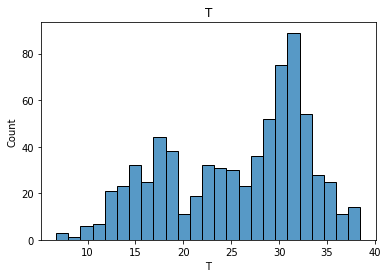

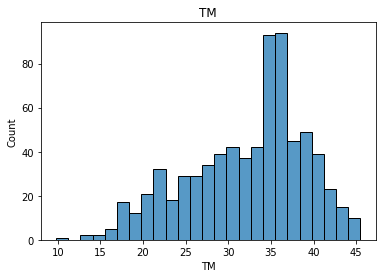

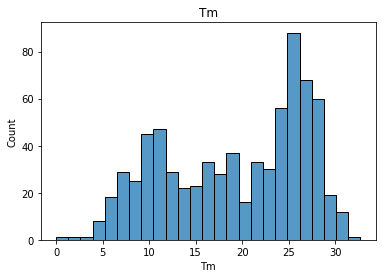

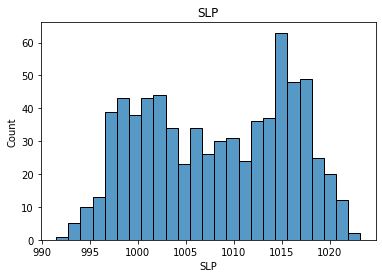

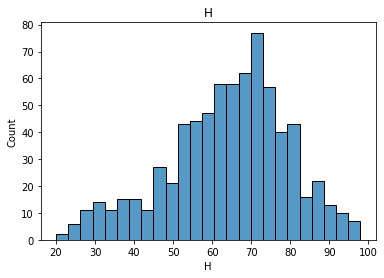

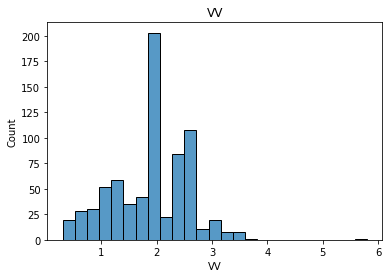

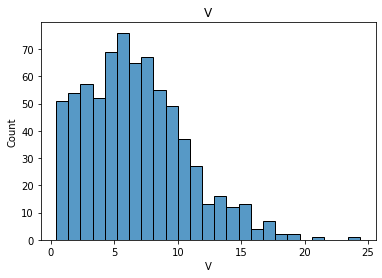

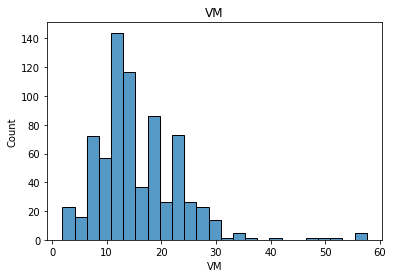

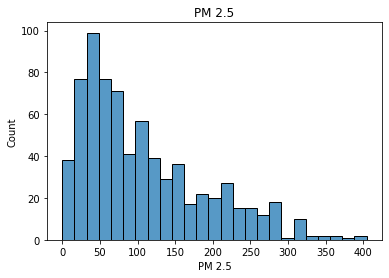

In [22]:
for feature in continous_feature:
    data = df.copy()
    sns.histplot(x=feature,data=data,bins=25)
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.title(feature)
    plt.show()

In above figure , We can see that distribution is Skewed i-e Log Normal Distribution , We will have to do Feature Transformation in Feature Engineering if we dont use any ensemble techniques

##### Relationship between Continous Features (Independent Variables) and Dependent Variable

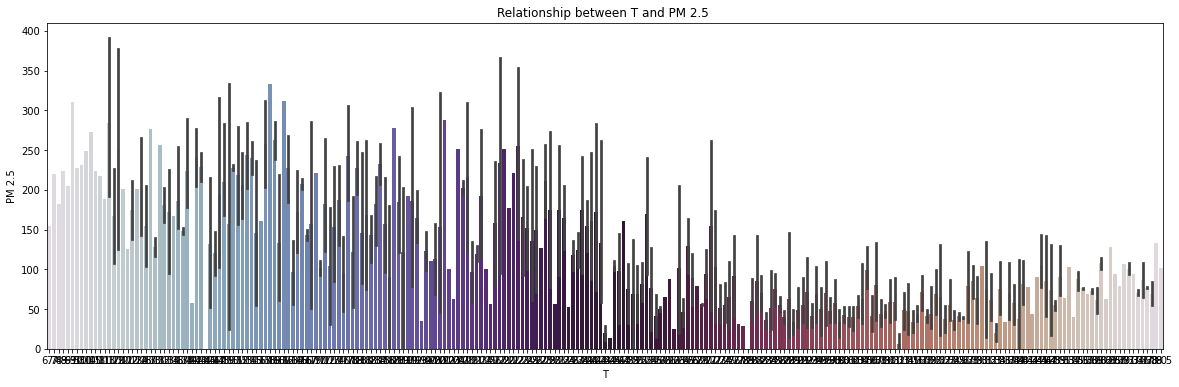

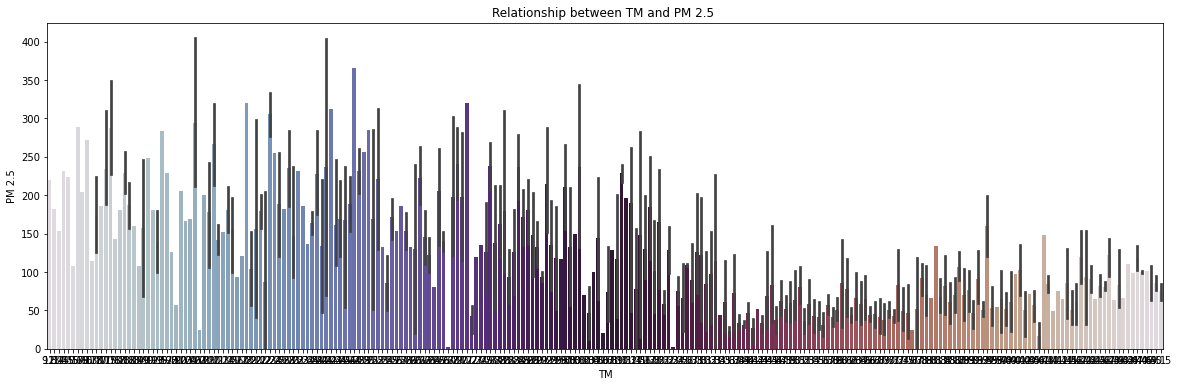

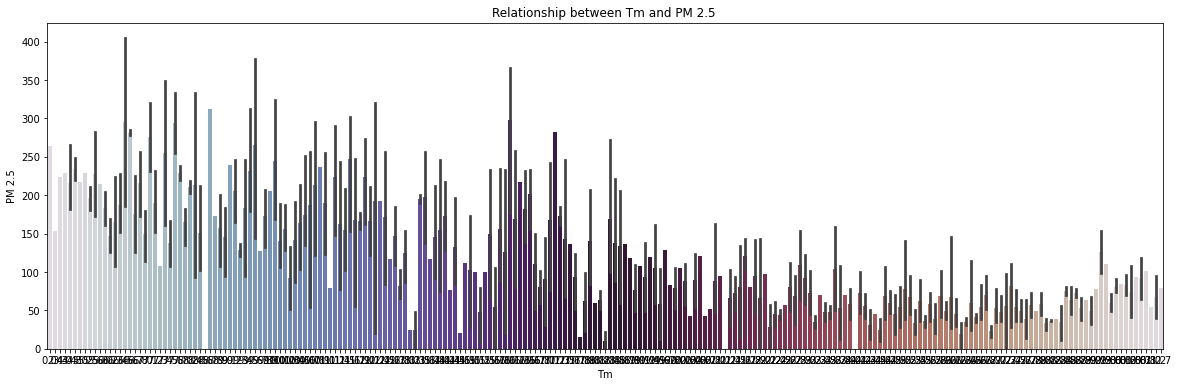

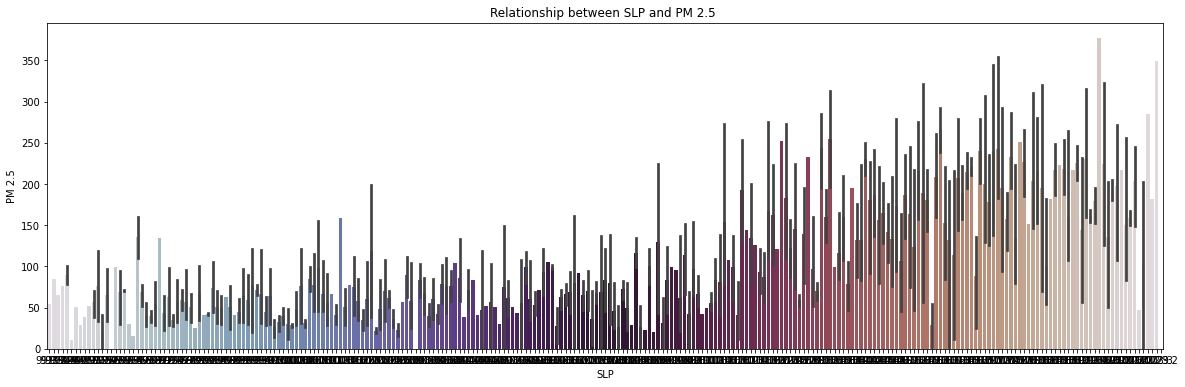

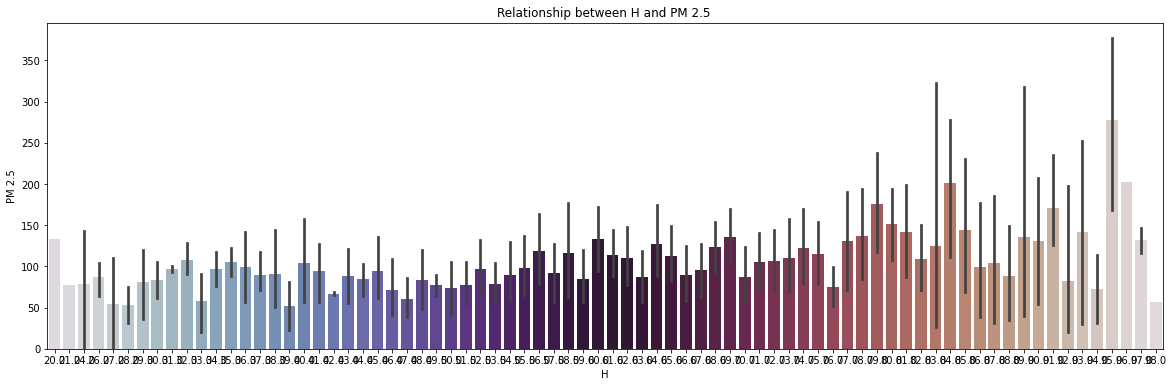

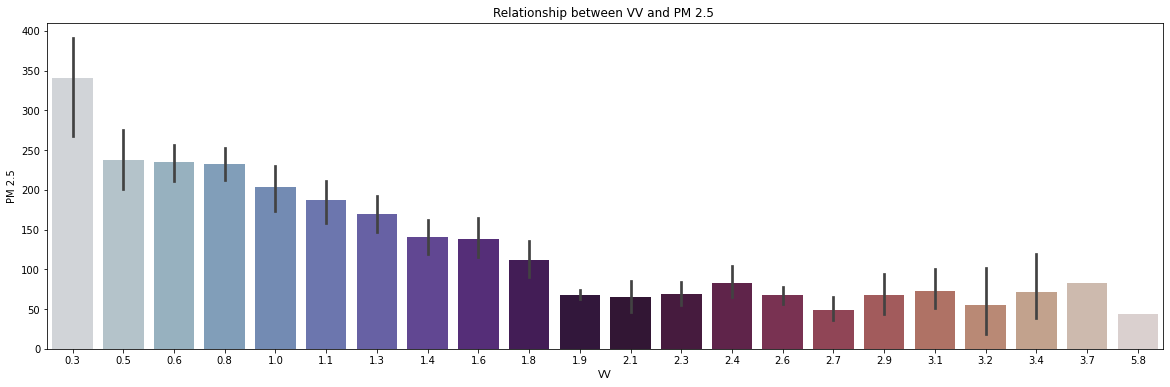

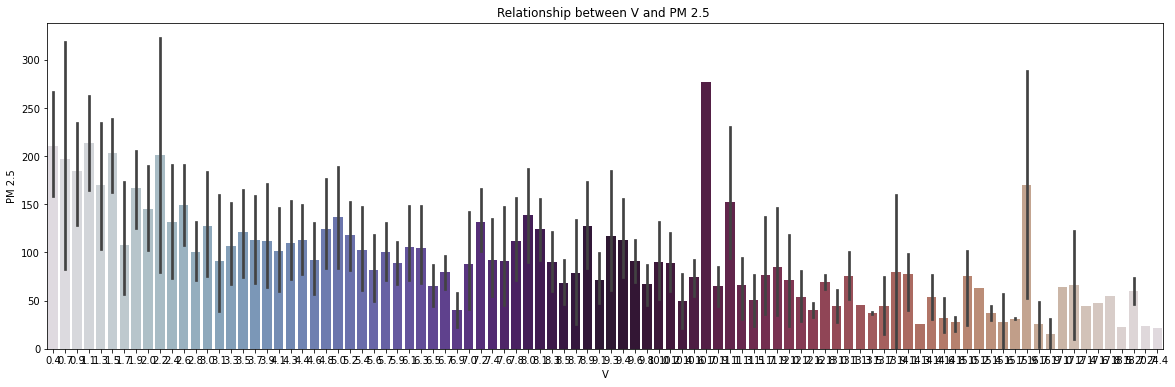

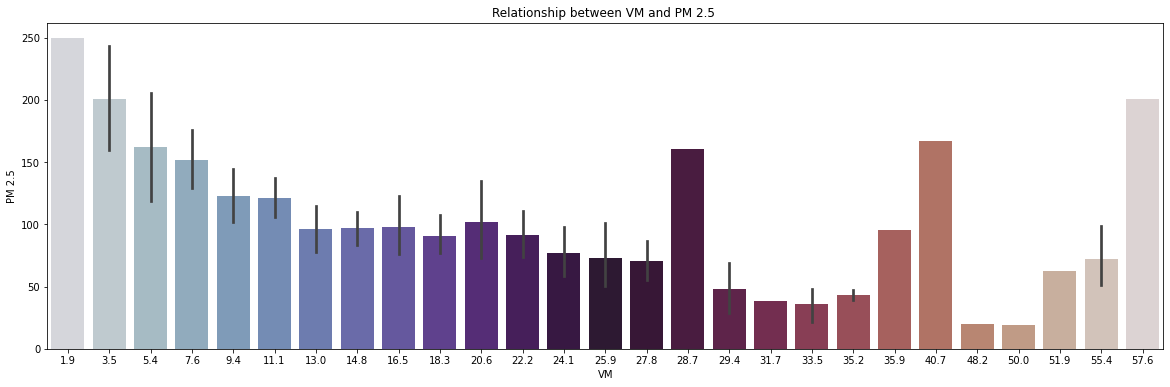

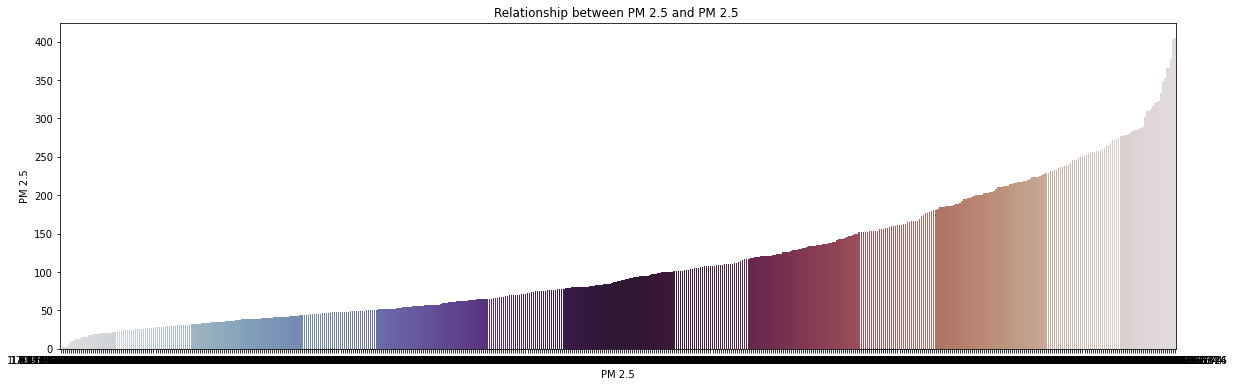

In [29]:
from matplotlib.pyplot import figure
import warnings
warnings.filterwarnings('ignore')
for feature in continous_feature:
    figure(figsize=(20,6))
    sns.barplot(df[feature],df['PM 2.5'],palette='twilight')
    plt.title('Relationship between {} and PM 2.5 '.format(feature))
    plt.show()

### Outliers



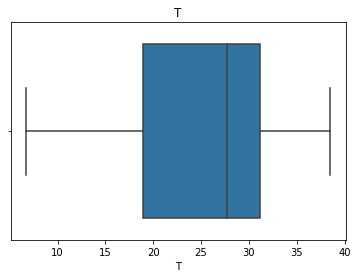

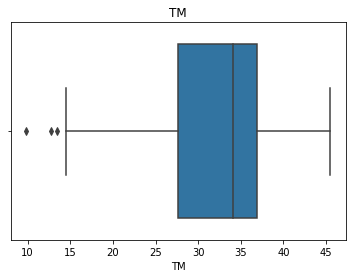

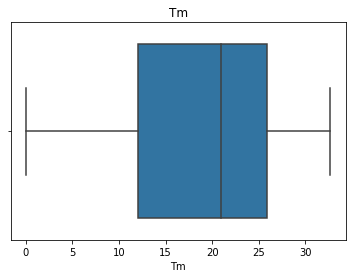

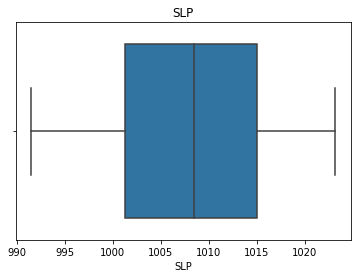

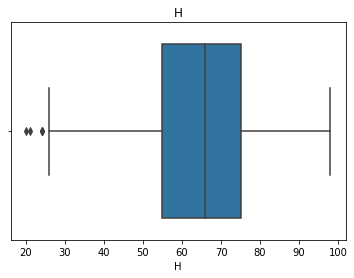

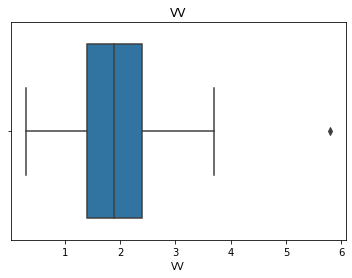

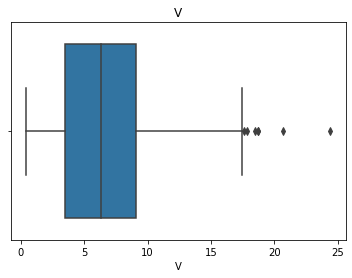

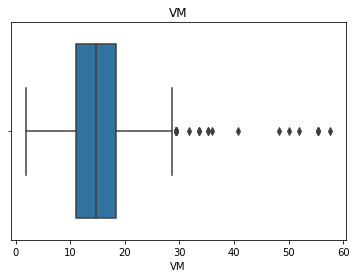

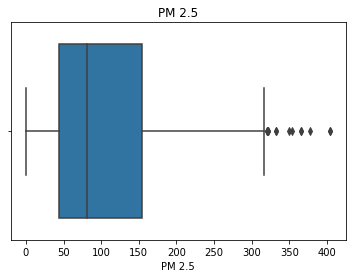

In [30]:
for feature in continous_feature:
    sns.boxplot(x=feature,data=df)
    plt.title(feature)
    plt.show()

### Step 3 - Feature Engineering

- Handling Imabalanced Dataset in Classification Problem - Not Required for this Use Case
- Handling Mising Values 
- Handling Outliers 
- Categorical Encoding - Not Required for this Use Case
- Feature Transformation

#### Handling Missing Values


In [35]:
### Removing Null Values : Because there is only One Row which has Null Value in Column PM2.5
df = df.dropna()
df.isnull().sum()

T         0
TM        0
Tm        0
SLP       0
H         0
VV        0
V         0
VM        0
PM 2.5    0
dtype: int64

##### Handling Outliers

Algorithms that are Sensitive/Not Sensitive to outlier:

1. Linear and Logistic Regresssion - Sensitive -- Remove
2. Decision Tree Classifier/Regressor - Not Sensitive -- Keep
3. Naive Bayes Classifier - Not Sensitive -- keep
4. SVM,Ensemble,KNN - Not Sensitive --keep

So further we will be using Linear Regression -- Remove outlier and will create a new dataframe 

For Ensemble techniques we will not remove an outlier and will train our model on original dataset

In [52]:
dataset_norm_reg = df.copy()
dataset_norm_reg.head()

,T,TM,Tm,SLP,H,VV,V,VM,PM 2.5
0,7.4,9.8,4.8,1017.6,93.0,0.5,4.3,9.4,219.720833
1,7.8,12.7,4.4,1018.5,87.0,0.6,4.4,11.1,182.187500
2,6.7,13.4,2.4,1019.4,82.0,0.6,4.8,11.1,154.037500
3,8.6,15.5,3.3,1018.7,72.0,0.8,8.1,20.6,223.208333
4,12.4,20.9,4.4,1017.3,61.0,1.3,8.7,22.2,200.645833


In [53]:
def lower_upper_not_normal_outlier(features):
  for feature in features:
    iqr = dataset_norm_reg[feature].quantile(0.75) - dataset_norm_reg[feature].quantile(0.25)
    lower_bridge = dataset_norm_reg[feature].quantile(0.25) - (iqr * 3)
    upper_bridge = dataset_norm_reg[feature].quantile(0.75) + (iqr * 3)
    print(feature,'\n')
    print('Lower Extreme Value : ',lower_bridge) , print('Upper Extreme Value : ',upper_bridge)
    print('\n')

lower_upper_not_normal_outlier(['T','TM','Tm','SLP','H','VV','V','VM'])

T 

Lower Extreme Value :  -18.000000000000007
Upper Extreme Value :  68.10000000000001


TM 

Lower Extreme Value :  -0.29999999999999005
Upper Extreme Value :  64.79999999999998


Tm 

Lower Extreme Value :  -29.599999999999994
Upper Extreme Value :  67.52499999999999


SLP 

Lower Extreme Value :  960.1999999999998
Upper Extreme Value :  1056.1000000000001


H 

Lower Extreme Value :  -5.0
Upper Extreme Value :  135.0


VV 

Lower Extreme Value :  -1.6
Upper Extreme Value :  5.4


V 

Lower Extreme Value :  -13.299999999999997
Upper Extreme Value :  25.9


VM 

Lower Extreme Value :  -10.500000000000002
Upper Extreme Value :  39.900000000000006




We will not consider Lower Values because it cannot be negative in our dataset,We will mainly focus on Upper Extreme Values and will replace the values greater than extreme values with extreme values in the dataset .

Now After Verifying the Extreme values for all features with Code . We Found out 2 Features are having Major Outliers -- 'VV' , 'VM'

In [54]:
dataset_norm_reg[dataset_norm_reg['VV'] > 5.4]

,T,TM,Tm,SLP,H,VV,V,VM,PM 2.5
646,33.6,36.7,28.8,996.7,66.0,5.8,5.9,11.1,43.666667


In [55]:
dataset_norm_reg[dataset_norm_reg['VM'] > 39.9]

,T,TM,Tm,SLP,H,VV,V,VM,PM 2.5
103,29.1,33.8,23.9,996.3,86.0,1.4,2.6,55.4,70.583333
134,28.7,34.1,25.2,1002.9,76.0,1.9,9.6,51.9,62.375000
181,13.6,20.4,7.5,1020.7,67.0,1.1,10.2,40.7,166.916667
202,18.6,27.8,8.9,1014.4,65.0,1.3,5.6,57.6,200.916667
262,32.9,41.6,25.6,1003.0,44.0,2.9,17.4,55.4,44.791667
309,29.5,35.3,24.6,1001.1,71.0,2.3,10.9,48.2,19.541667
412,28.6,36.5,20.3,1012.4,59.0,1.8,9.3,55.4,109.750000
439,31.4,41.5,24.9,1002.2,50.0,1.8,14.8,50.0,18.875000
443,35.3,45.5,24.4,999.2,33.0,2.3,17.0,55.4,63.916667


##### Replacing Values of above Features which are having Outliers

In [56]:
dataset_norm_reg.loc[dataset_norm_reg['VV']>5.4,'VV']=5.4
dataset_norm_reg.loc[dataset_norm_reg['VM']>39.9,'VM']=39.9
display(dataset_norm_reg[dataset_norm_reg['VV'] > 5.4])
display(dataset_norm_reg[dataset_norm_reg['VM'] > 39.9])

,T,TM,Tm,SLP,H,VV,V,VM,PM 2.5


,T,TM,Tm,SLP,H,VV,V,VM,PM 2.5


#### Feature Transformation

- Since we dont need to do transformation If we are using Ensemble Technique , So Feature transformation will only be applied for dataset_norm_reg.Becuase Linear,Ridge,Lasso Regression will be applied on these dataframe.Ensemble Technique will be applied on 'dataset' dataframe.

- To Apply feature transformation , We first need to identify whether each feature is normally distributed or not.If feature is normally distributed then we will apply - StandardScaler /MinMaxScaler /RobustScaler

- If features is not normally distributed we will apply - Gaussian Transformation

###### Identifying Feature Distribution using QQ plot

If All points fall in same line then we can say that it is Normally Distributed

T 



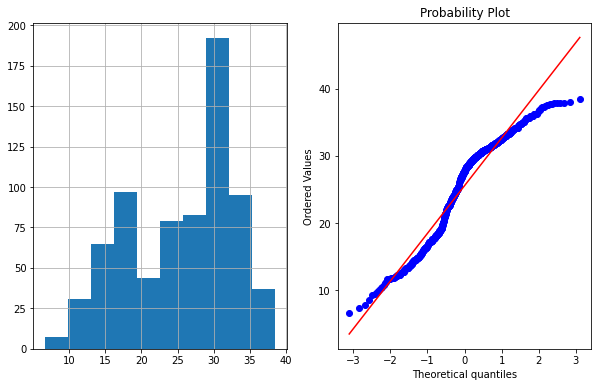



TM 



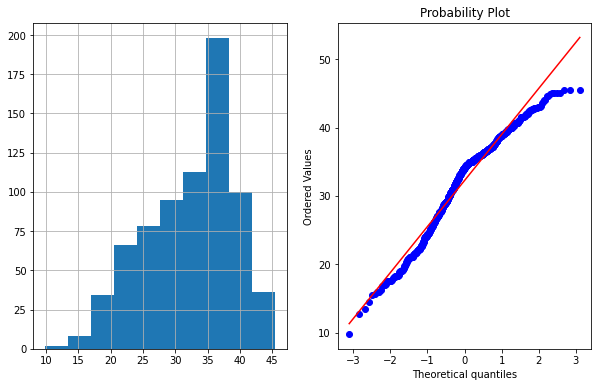



Tm 



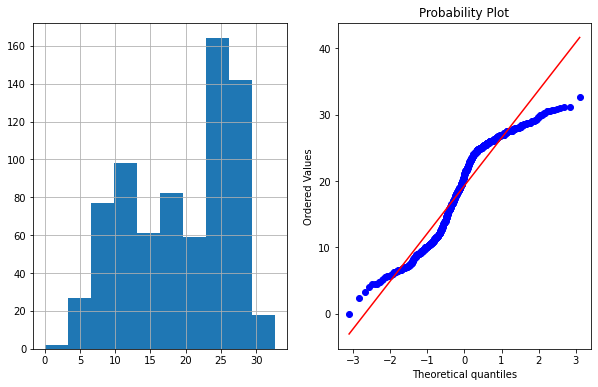



SLP 



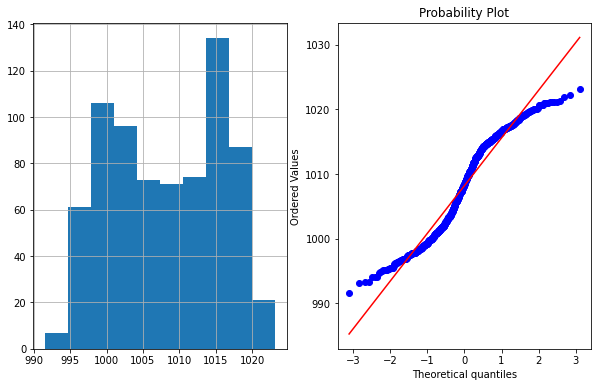



H 



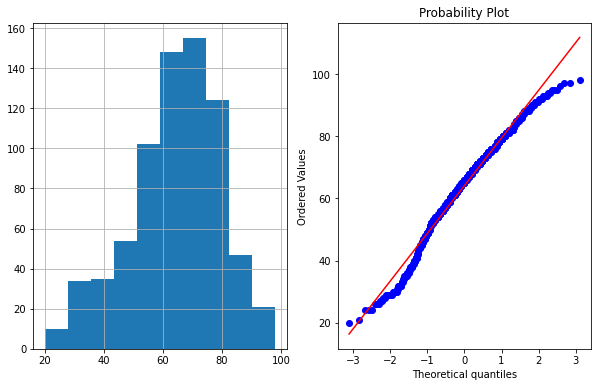



VV 



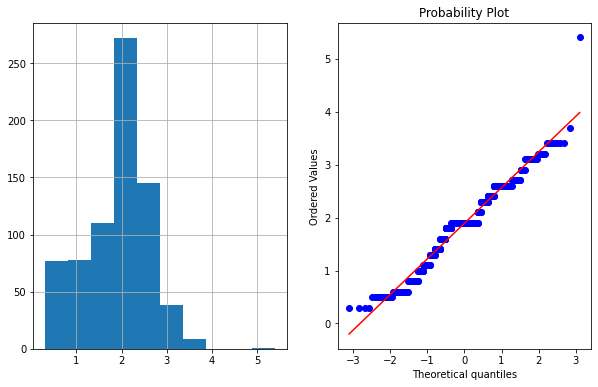



V 



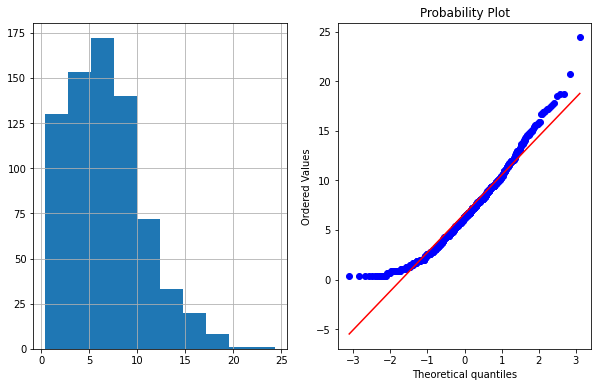



VM 



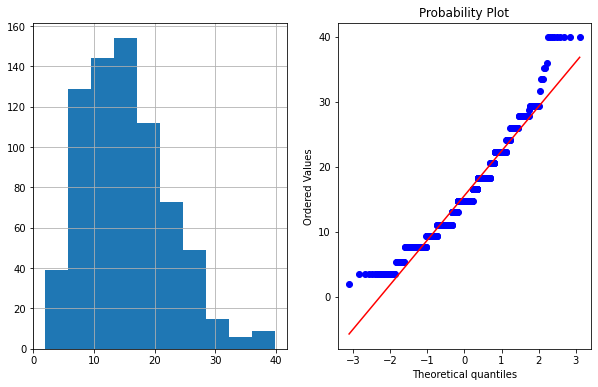

In [58]:
import scipy.stats as stat
import pylab
def plot_data(df,features):
  for feature in features:
    print(feature , '\n')
    plt.figure(figsize=(10,6))
    plt.subplot(1,2,1)
    df[feature].hist()
    plt.subplot(1,2,2)
    stat.probplot(df[feature],dist='norm',plot=pylab)
    plt.show()
    print('\n')

plot_data(dataset_norm_reg,['T','TM','Tm','SLP','H','VV','V','VM'])

Since Most of the points in Each Feature fall in same line , We can that it is normally distributed. So we can StandardScaler or Min Max Scaler or Robust Scaler.

We can also apply various other Transformation Techniques and check whether there is a change in Accuracy.For now we will apply simple transformation technique - Standard Scaler while Model Building Stage.

#### Dividing Dataset into Independent and Dependent Features ---- For Ensemble Techniques


In [12]:
from IPython.display import display
X = df.iloc[:,:-1] ## Independent Features
y = df.iloc[:,-1] ## Dependent Features
display(X.head())
display(y.head())

,T,TM,Tm,SLP,H,VV,V,VM
0,7.4,9.8,4.8,1017.6,93.0,0.5,4.3,9.4
1,7.8,12.7,4.4,1018.5,87.0,0.6,4.4,11.1
2,6.7,13.4,2.4,1019.4,82.0,0.6,4.8,11.1
3,8.6,15.5,3.3,1018.7,72.0,0.8,8.1,20.6
4,12.4,20.9,4.4,1017.3,61.0,1.3,8.7,22.2


0    219.720833
1    182.187500
2    154.037500
3    223.208333
4    200.645833
Name: PM 2.5, dtype: float64

In [61]:
X_norm_reg = dataset_norm_reg.iloc[:,:-1]
y_norm_reg = dataset_norm_reg.iloc[:,-1]
display(X_norm_reg.head())
display(y_norm_reg.head())

,T,TM,Tm,SLP,H,VV,V,VM
0,7.4,9.8,4.8,1017.6,93.0,0.5,4.3,9.4
1,7.8,12.7,4.4,1018.5,87.0,0.6,4.4,11.1
2,6.7,13.4,2.4,1019.4,82.0,0.6,4.8,11.1
3,8.6,15.5,3.3,1018.7,72.0,0.8,8.1,20.6
4,12.4,20.9,4.4,1017.3,61.0,1.3,8.7,22.2


0    219.720833
1    182.187500
2    154.037500
3    223.208333
4    200.645833
Name: PM 2.5, dtype: float64